# Comparing Representations

---

*Features*

- 7 representations are evaluated using various plots and metrics (accuracy, precision, recall):
    1. New features alone
    2. Bag-of-(upto)-Trigrams alone
    3. BoT + new features
    4. BoT + document lengths (first and best feature)
    5. SVD (min max scaled) on the BoT
    6. SVD (min max scaled) on the BoT + all features
    7. SVD (min max scaled) on the BoT + document lengths

*Results*

- Given our baseline logistic classifier:
    * The new features alone aren't useful
    * The BoT is still our best model and doesn't improve with added features
    * SVD alone has very low recall
    * SVD and all new features improve little
    * SVD and document length improves the model

*Decision*

- Keep best two representations:
    * BoT alone
    * SVD with new features - for testing with more complex models


### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-20


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### Create 7 Representations

#### 1. New Features

In [3]:
%%capture output

# custom feature engineering module
import custom.feature_engineering as Fe

try:                   
    clean_train_docs, X_train_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass

# impute with zeros
X_train_feat[np.isnan(X_train_feat)] = 0

#### 2. BoT

A Bag-of-upto-Trigrams with a vocabulary size of 2,000 terms.

In [4]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

dtm_pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                     ('bow', cp.WordCounterToVectorTransformer(vocabulary_size=2000))
                    ])

X_train_bot = dtm_pipe.fit_transform(X_train)

#### 3. BoT + Features

In [5]:
import scipy.sparse as sp

X_train_bot_feat = sp.hstack((X_train_feat, X_train_bot))

#### 4. BoT + Doc Length

In [6]:
X_train_bot_doclen = sp.hstack((X_train_feat[:, 0:1], X_train_bot))

#### 5. SVD on BoW

In [7]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MinMaxScaler

def perform_SVD(X, n_topics=300):
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, k=n_topics)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    # return V (for now)
    V = VT.T
    return V

X_train_svd = perform_SVD(X_train_bot)

# scale for precision/recall calcs
scaler = MinMaxScaler()
X_train_svd_scaled = scaler.fit_transform(X_train_svd)

# make sparse for stacking
X_train_svd_scaled = sp.csr_matrix(X_train_svd_scaled)

#### 6. SVD-on-BoT + Features

In [8]:
X_train_svd_feat = sp.hstack((X_train_svd_scaled, X_train_feat))

#### 7. SVD-on-BoT + DocLen

In [9]:
X_train_svd_doclen = sp.hstack((X_train_svd_scaled, (X_train_feat[:, 0:1])))

### Train Logistic Classifier

A quick modeling phase with a baseline classifier to compare our 7 candidate representations:

1. **X_train_feat:** new features
2. **X_train_bot:** bag-of-upto-trigrams (bot)
3. **X_train_bot_feat:** bot + all features
4. **X_train_bot_doclen:** bot + document lengths (first and best feature)
5. **X_train_svd_scaled:** svd (min max scaled) on the bot
6. **X_train_svd_feat:** svd on the bot + all features
7. **X_train_svd_doclen:** svd on the bot + document lengths

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def get_modeling_stats(Xs, Xnames, y, cv=10):
    # instantiate lists
    accs_, pres_, recs_ = [], [], []    
    # for model in models:
    for X in Xs:
        # instantiate classifier
        log_clf = LogisticRegression(solver="liblinear", random_state=42)
        # train and evaluate
        accs = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='accuracy')
        pres = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='precision')
        recs = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='recall')
        # gather results
        accs_.append(np.round(accs, 4))
        pres_.append(np.round(pres, 4))
        recs_.append(np.round(recs, 4))
    
    data = {'representations':Xnames,
            'accuracies':accs_,
            'precisions':pres_,
            'recalls':recs_}
    
    return pd.DataFrame(data)

In [11]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

In [12]:
# list of models
Xs = [
      X_train_feat, 
      X_train_bot, 
      X_train_bot_feat, 
      X_train_bot_doclen,
      X_train_svd_scaled,
      X_train_svd_feat,
      X_train_svd_doclen
     ]
# list of names (for dfm)
Xnames = [
          'X_train_feat',       # 1. new feat
          'X_train_bot',        # 2. bot
          'X_train_bot_feat',   # 3. bot + new feats
          'X_train_bot_doclen', # 4. bot + doc lens
          'X_train_svd_scaled', # 5. svd
          'X_train_svd_feat',   # 6. svd on bot + new feats
          'X_train_svd_doclen'  # 7. svd on bot + doc lens
         ]
# run
df = get_modeling_stats(Xs, Xnames, y_train)

In [13]:
df

,representations,accuracies,precisions,recalls
0,X_train_feat,"[0.8974, 0.8795, 0.8769, 0.8769, 0.8897, 0.866...","[0.6667, 0.5625, 0.5714, 0.5714, 0.6452, 0.5, ...","[0.4314, 0.3529, 0.2353, 0.3077, 0.3846, 0.307..."
1,X_train_bot,"[0.9795, 0.9872, 0.9744, 0.9897, 0.9872, 0.982...","[0.9574, 0.9792, 1.0, 1.0, 0.9796, 0.9787, 1.0...","[0.8824, 0.9216, 0.8039, 0.9231, 0.9231, 0.884..."
2,X_train_bot_feat,"[0.9769, 0.9821, 0.9718, 0.9872, 0.9872, 0.979...","[0.9375, 0.94, 1.0, 1.0, 0.9796, 0.9583, 1.0, ...","[0.8824, 0.9216, 0.7843, 0.9038, 0.9231, 0.884..."
3,X_train_bot_doclen,"[0.9744, 0.9872, 0.9718, 0.9872, 0.9872, 0.979...","[0.9362, 0.9792, 1.0, 1.0, 0.9796, 0.9583, 1.0...","[0.8627, 0.9216, 0.7843, 0.9038, 0.9231, 0.884..."
4,X_train_svd_scaled,"[0.9615, 0.9718, 0.9615, 0.959, 0.9718, 0.9692...","[0.9286, 0.9545, 1.0, 1.0, 1.0, 0.9762, 1.0, 0...","[0.7647, 0.8235, 0.7059, 0.6923, 0.7885, 0.788..."
5,X_train_svd_feat,"[0.959, 0.9769, 0.9538, 0.9667, 0.9718, 0.9564...","[0.8571, 0.92, 0.9459, 0.9535, 0.9556, 0.8889,...","[0.8235, 0.902, 0.6863, 0.7885, 0.8269, 0.7692..."
6,X_train_svd_doclen,"[0.959, 0.9718, 0.959, 0.9615, 0.9744, 0.9538,...","[0.8889, 0.9348, 0.973, 0.9744, 0.9565, 0.84, ...","[0.7843, 0.8431, 0.7059, 0.7308, 0.8462, 0.807..."


In [14]:
# calc means for plotting
mean_accs  = [round(np.mean(x),4) for x in df.loc[:,"accuracies"]]
mean_precs = [round(np.mean(x),4) for x in df.loc[:,"precisions"]]
mean_recs  =  [round(np.mean(x),4) for x in df.loc[:,"recalls"]]

### Evaluate 7 Representations

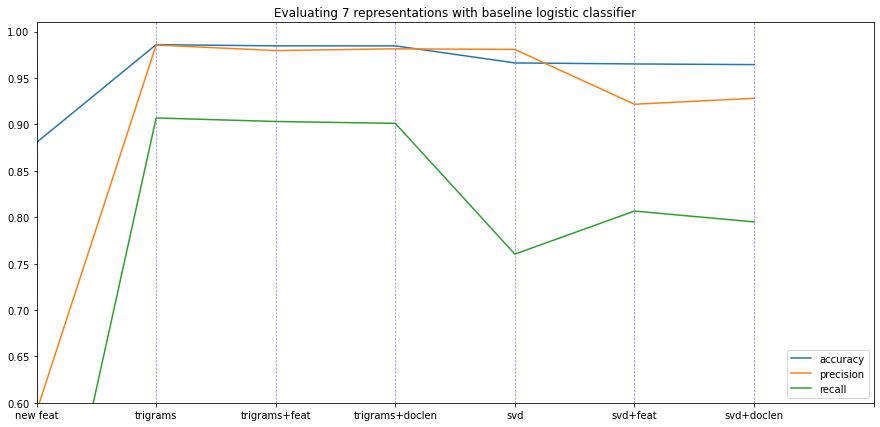

In [15]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 7)) 
plt.plot(mean_accs, label="accuracy")
plt.plot(mean_precs, label="precision")
plt.plot(mean_recs, label="recall")
plt.title('Evaluating 7 representations with baseline logistic classifier')
plt.xticks(np.arange(9), ('new feat', 
                          'trigrams', 
                          'trigrams+feat', 
                          'trigrams+doclen',
                          'svd', 
                          'svd+feat',
                          'svd+doclen'))
plt.vlines(np.arange(9), ymin=.6, ymax=1.01, linestyle='dashed', colors='b', alpha=.5, linewidth=.7)
plt.legend(loc="lower right")
plt.axis([0, 7, 0.6, 1.01])
plt.show()

*Results*

- The new features alone aren't useful (as expected)
- The bag-of-trigrams does not improve with new features (or just the best feature)
- SVD alone has slightly lower accuracy and very low recall
- SVD plus new features (or just doc length) improves recall a bit, but drops precision

*Keep*

- trigrams alone
- SVD with new features; test with more complex models


### Precision-Recall Curves

PR curves confirm above findings except for SVD v. SVD plus features, the latter seems to have made things worse. 

This result is less robust however (no CV).

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_PR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    log_clf.fit(X_train, y_train)
    p = plot_precision_recall_curve(log_clf, X_test, y_test)

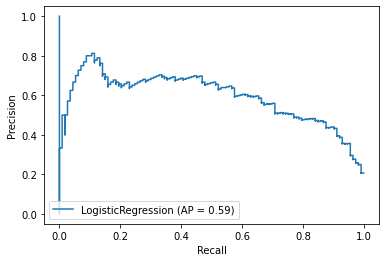

In [17]:
plot_PR(X_train_feat, y_train)

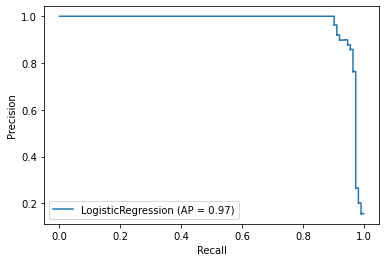

In [18]:
plot_PR(X_train_bot, y_train)

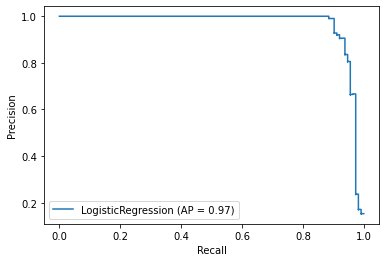

In [19]:
plot_PR(X_train_bot_feat, y_train)

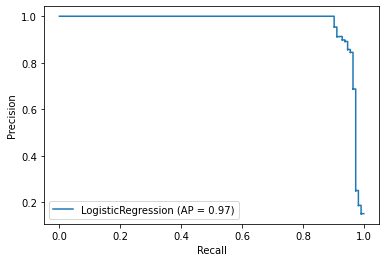

In [21]:
plot_PR(X_train_bot_doclen, y_train)

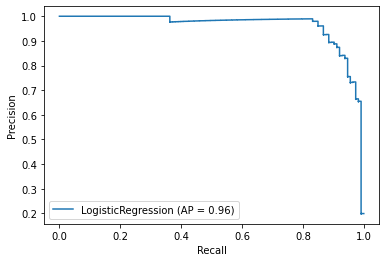

In [22]:
plot_PR(X_train_svd_scaled, y_train)

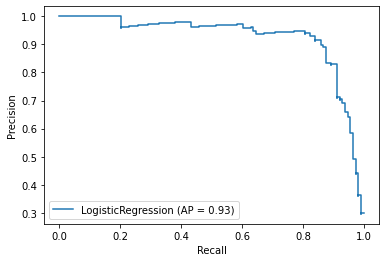

In [23]:
plot_PR(X_train_svd_feat, y_train)

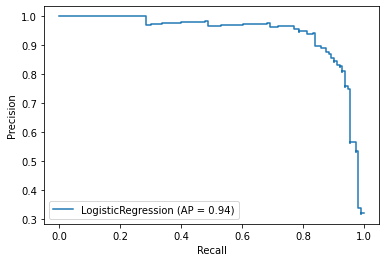

In [24]:
plot_PR(X_train_svd_doclen, y_train)

In [25]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 4 m 41 s


---